In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import koreanize_matplotlib

In [2]:
performance_df = pd.read_csv("../datasets/KOPIS/performance/performance_cleaned.csv")

In [93]:
price_stats = pd.read_csv("../datasets/KOPIS/statics/가격대별예매통계.csv")

In [4]:
time_stats = pd.read_csv("../datasets/KOPIS/statics/시간대별예매통계.csv")

In [5]:
genre_stats = pd.read_csv("../datasets/KOPIS/statics/장르별예매통계.csv")

In [6]:
genre_service = pd.read_csv("../datasets/KOPIS/statics/장르별통계목록.csv")

In [94]:
# 가격대 전처리

# 매핑 딕셔너리
price_map = {
    "0원": "0",
    "3만원미만": "~3",
    "3만원이상~5만원미만": "3~5",
    "5만원이상~7만원미만": "5~7",
    "7만원이상~10만원미만": "7~10",
    "10만원이상~15만원미만": "10~15",
    "15만원이상": "15~"
}

price_stats['가격대'] = price_stats['가격대'].map(price_map)

In [96]:
price_stats.to_csv("../datasets/KOPIS/statics/가격대별예매통계.csv", index=False, encoding="utf-8-sig")

In [8]:
import re

def to_hour_group(x):
    # "00:00 ~ 2:59" → "0-3"
    # "3:00 ~ 5:59"  → "3-6"
    start = re.match(r"(\d+):", x)
    if start:
        start_hour = int(start.group(1))
        # 끝나는 시각은 +3
        end_hour = start_hour + 3
        return f"{start_hour}-{end_hour}"
    return None

time_stats["시간대_그룹"] = time_stats["시간대"].apply(to_hour_group)

In [9]:
def to_daypart(x):
    if pd.isna(x):
        return np.nan
    # "0-3", "3-6" 같은 문자열을 받아서 주간/저녁/심야로 변환
    start = int(x.split("-")[0])  # 시작 시간
    if 9 <= start < 18:
        return "주간"
    elif 18 <= start < 24:
        return "저녁"
    else:
        return "심야"

# 그 그룹을 주간/저녁/심야로 묶기
time_stats["시간대_대분류"] = time_stats["시간대_그룹"].apply(to_daypart)

In [107]:
time_stats.to_csv("../datasets/KOPIS/statics/시간대별예매통계.csv", index=False, encoding="utf-8-sig")

In [108]:
time_stats.to_csv("../streamlit_play/datasets/시간대별예매통계.csv", index=False, encoding="utf-8-sig")

In [10]:
performance_play = performance_df[performance_df["공연장르명"] == "연극"].copy()

In [11]:
# 공연시작일 기준으로 연도 추출
performance_play["공연시작일"] = pd.to_datetime(performance_play["공연시작일"], errors="coerce")
performance_play["공연종료일"] = pd.to_datetime(performance_play["공연종료일"], errors="coerce")

start_date = pd.to_datetime("2023-01-01")
end_date   = pd.to_datetime("2024-12-31")

# 2023~2024 데이터만 필터링
mask = (performance_play["공연시작일"] <= end_date) & (performance_play["공연종료일"] >= start_date)
performance_play = performance_play.loc[mask].copy()

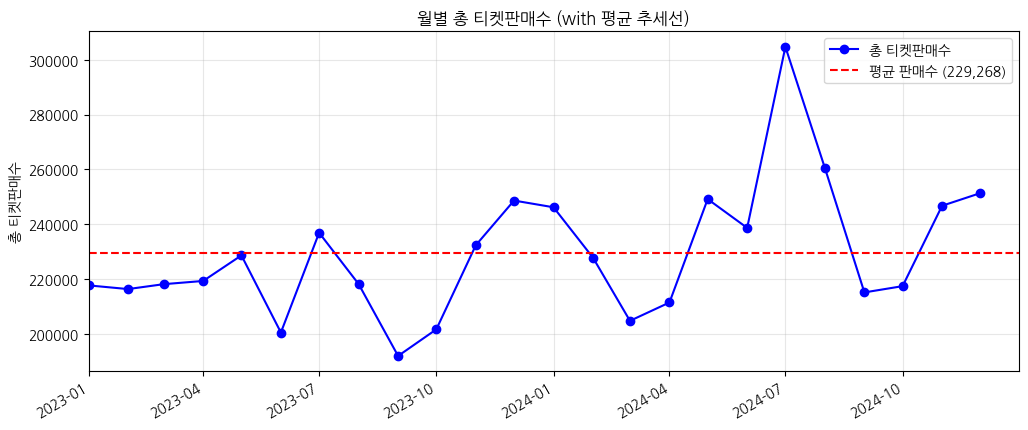

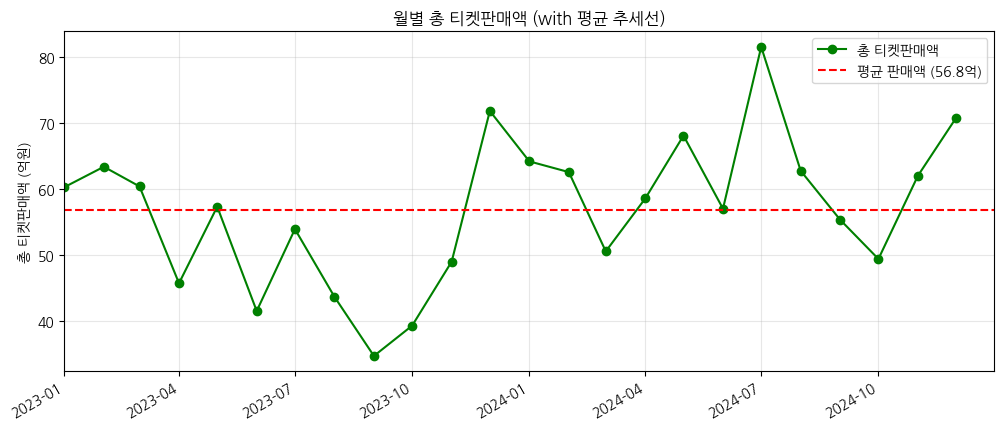

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# 날짜 컬럼 datetime 변환
genre_stats["날짜"] = pd.to_datetime(genre_stats["날짜"], format="%Y%m%d", errors="coerce")

# 월 단위 집계
monthly_stats = (
    genre_stats.groupby(pd.Grouper(key="날짜", freq="MS"))
    .agg({"총 티켓판매수": "sum", "총 티켓판매액": "sum"})
    .reset_index()
)

# ===============================
# 1. 총 티켓판매수 (line + 평균 추세선)
# ===============================
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(monthly_stats["날짜"], monthly_stats["총 티켓판매수"], 
        marker="o", color="blue", label="총 티켓판매수")

# 평균선
mean_count = monthly_stats["총 티켓판매수"].mean()
ax.axhline(mean_count, color="red", linestyle="--", label=f"평균 판매수 ({mean_count:,.0f})")

# x축 포맷
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2024-12-31"))

plt.title("월별 총 티켓판매수 (with 평균 추세선)")
plt.ylabel("총 티켓판매수")
plt.legend()
plt.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.show()

# ===============================
# 2. 총 티켓판매액 (line + 평균 추세선)
# ===============================
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(monthly_stats["날짜"], monthly_stats["총 티켓판매액"]/1e8, 
        marker="o", color="green", label="총 티켓판매액")

# 평균선
mean_sales = (monthly_stats["총 티켓판매액"]/1e8).mean()
ax.axhline(mean_sales, color="red", linestyle="--", 
           label=f"평균 판매액 ({mean_sales:.1f}억)")

# x축 포맷
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2024-12-31"))

plt.title("월별 총 티켓판매액 (with 평균 추세선)")
plt.ylabel("총 티켓판매액 (억원)")
plt.legend()
plt.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.show()


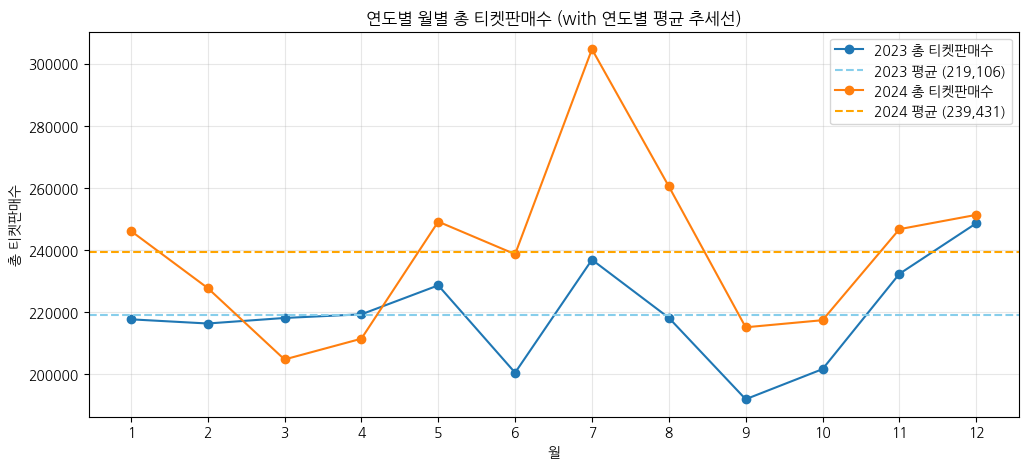

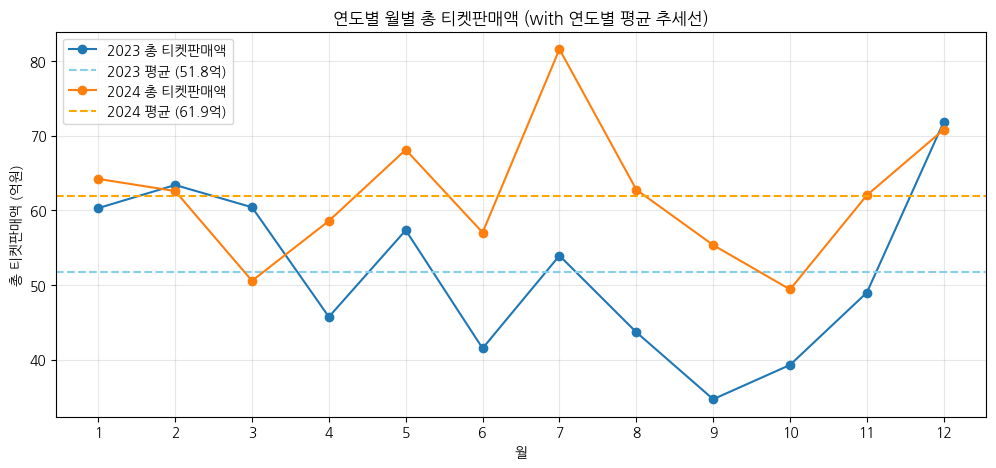

In [66]:
# ===============================
# 1. 월별 총 티켓판매수 (연도별)
# ===============================
fig, ax = plt.subplots(figsize=(12,5))

monthly_stats["연도"] = monthly_stats["날짜"].dt.year
monthly_stats["월"] = monthly_stats["날짜"].dt.month

for year in [2023, 2024]:
    data = monthly_stats[monthly_stats["연도"] == year]
    ax.plot(data["월"], data["총 티켓판매수"], marker="o", label=f"{year} 총 티켓판매수")
    
    # 연도별 평균선 색상 지정
    y_mean = data["총 티켓판매수"].mean()
    if year == 2023:
        ax.axhline(y_mean, linestyle="--", color="skyblue", 
                   label=f"{year} 평균 ({y_mean:,.0f})")
    else:
        ax.axhline(y_mean, linestyle="--", color="orange", 
                   label=f"{year} 평균 ({y_mean:,.0f})")

plt.title("연도별 월별 총 티켓판매수 (with 연도별 평균 추세선)")
plt.xlabel("월")
plt.ylabel("총 티켓판매수")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ===============================
# 2. 월별 총 티켓판매액 (연도별)
# ===============================
fig, ax = plt.subplots(figsize=(12,5))

for year in [2023, 2024]:
    data = monthly_stats[monthly_stats["연도"] == year]
    ax.plot(data["월"], data["총 티켓판매액"]/1e8, marker="o", label=f"{year} 총 티켓판매액")
    
    # 연도별 평균선 색상 지정
    y_mean = (data["총 티켓판매액"]/1e8).mean()
    if year == 2023:
        ax.axhline(y_mean, linestyle="--", color="skyblue", 
                   label=f"{year} 평균 ({y_mean:.1f}억)")
    else:
        ax.axhline(y_mean, linestyle="--", color="orange", 
                   label=f"{year} 평균 ({y_mean:.1f}억)")

plt.title("연도별 월별 총 티켓판매액 (with 연도별 평균 추세선)")
plt.xlabel("월")
plt.ylabel("총 티켓판매액 (억원)")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
facility_df = pd.read_csv("../datasets/KOPIS/performance/facility_df.csv")

In [13]:
performance_with_facility = performance_play.merge(
    facility_df[['공연시설ID', '객석수', '시군구', '시도']],
    on='공연시설ID', 
    how='left'
)

In [14]:
# 객석수 기준 분류 함수
def classify_theater(seats):
    if pd.isna(seats):
        return "정보없음"
    elif seats >= 1000:
        return "대극장"
    elif seats >= 500:
        return "중극장"
    else:
        return "소극장"

In [15]:
performance_with_facility["극장규모"] = performance_with_facility["객석수"].apply(classify_theater)

In [16]:
# 무슨 연극이 열렸길래 24년 7월에 훅 뛰었나

peak_start = "2024-07-01"
peak_end   = "2024-07-31"

big_shows = performance_with_facility[
    (performance_with_facility["공연시작일"] <= peak_end) &
    (performance_with_facility["공연종료일"] >= peak_start)
].copy()

big_shows[big_shows['최대가격'] > 60000].sort_values(by='최대가격', ascending=False).to_csv("big_shows_in_202407.csv", index=False, encoding='utf-8-sig')

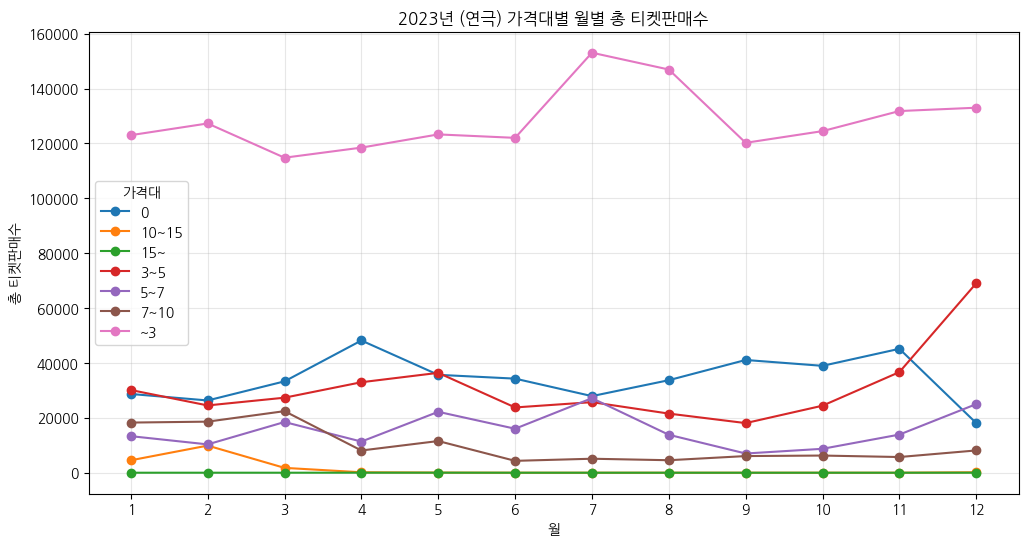

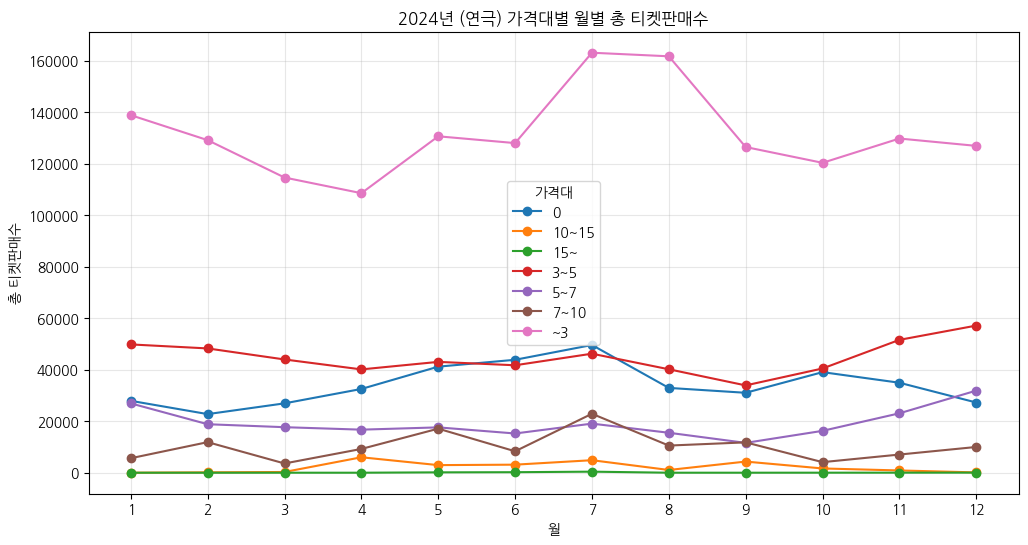

In [113]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. 날짜 변환 & 필터링
price_stats["날짜"] = pd.to_datetime(price_stats["날짜"], format="%Y%m%d", errors="coerce")
price_stats = price_stats.dropna(subset=["날짜"])

# 🎭 연극만 필터링
price_stats_play = price_stats[price_stats["장르"] == "연극"]

# 2. 연도 컬럼 추가
price_stats_play["연도"] = price_stats_play["날짜"].dt.year

# 3. 월 단위 집계
price_monthly = (
    price_stats_play.groupby([pd.Grouper(key="날짜", freq="M"), "가격대", "연도"])
    .agg({"총 티켓판매수": "sum"})
    .reset_index()
)

# 4. 연도별 그리기
for year in [2023, 2024]:
    yearly_data = price_monthly[price_monthly["연도"] == year].copy()
    
    # 월 컬럼 추가
    yearly_data["월"] = yearly_data["날짜"].dt.month
    
    # 피벗 (월 × 가격대)
    pivot_sales = yearly_data.pivot(index="월", columns="가격대", values="총 티켓판매수")
    
    # 그래프
    fig, ax = plt.subplots(figsize=(12,6))
    pivot_sales.plot(ax=ax, marker="o")
    
    plt.title(f"{year}년 (연극) 가격대별 월별 총 티켓판매수")
    plt.xlabel("월")
    plt.ylabel("총 티켓판매수")
    plt.xticks(range(1,13))
    plt.legend(title="가격대")
    plt.grid(True, alpha=0.3)
    plt.show()


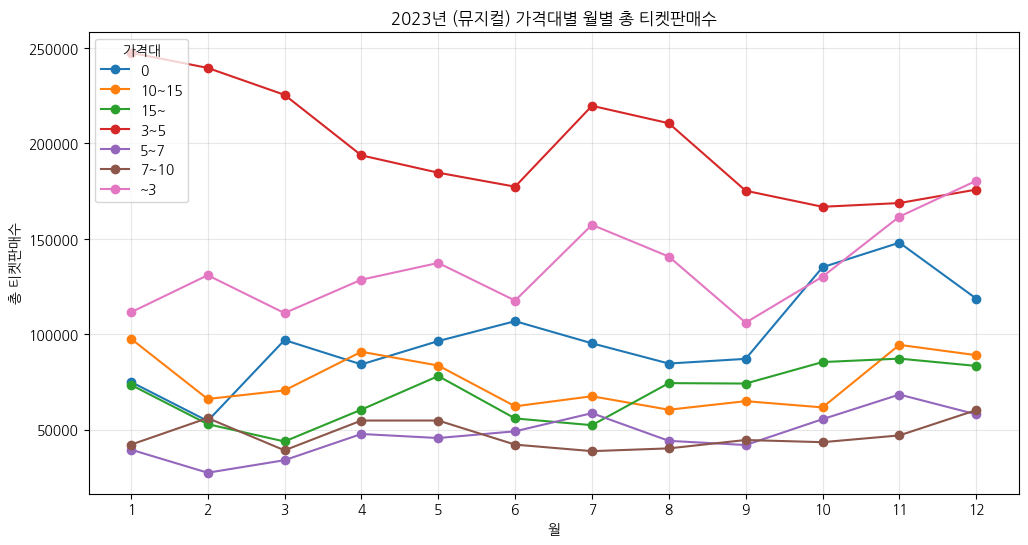

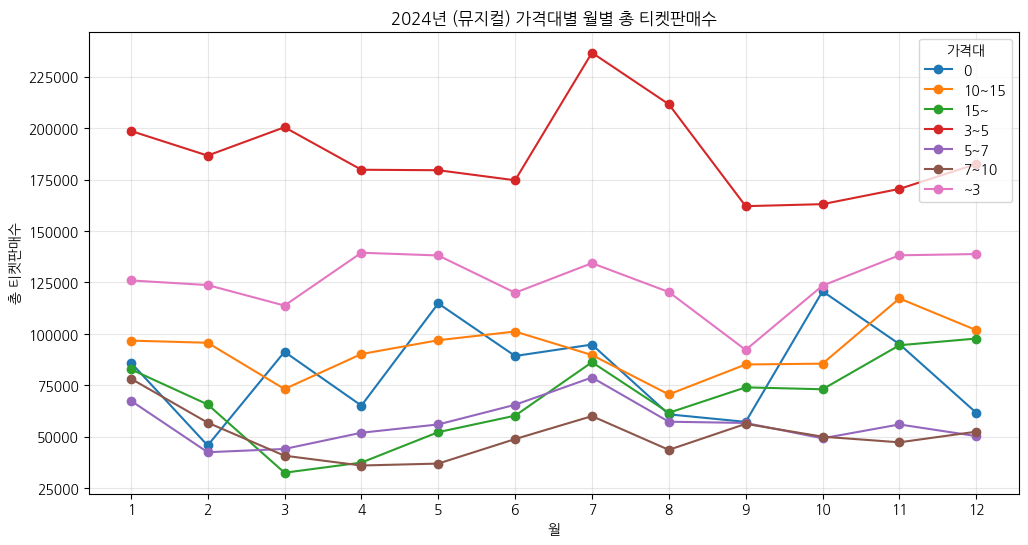

In [114]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. 날짜 변환 & 필터링
price_stats["날짜"] = pd.to_datetime(price_stats["날짜"], format="%Y%m%d", errors="coerce")
price_stats = price_stats.dropna(subset=["날짜"])

# 🎭 뮤지컬만 필터링
price_stats_musical = price_stats[price_stats["장르"] == "뮤지컬"]

# 2. 연도 컬럼 추가
price_stats_musical["연도"] = price_stats_musical["날짜"].dt.year

# 3. 월 단위 집계
price_monthly = (
    price_stats_musical.groupby([pd.Grouper(key="날짜", freq="M"), "가격대", "연도"])
    .agg({"총 티켓판매수": "sum"})
    .reset_index()
)

# 4. 연도별 그리기
for year in [2023, 2024]:
    yearly_data = price_monthly[price_monthly["연도"] == year].copy()
    
    # 월 컬럼 추가
    yearly_data["월"] = yearly_data["날짜"].dt.month
    
    # 피벗 (월 × 가격대)
    pivot_sales = yearly_data.pivot(index="월", columns="가격대", values="총 티켓판매수")
    
    # 그래프
    fig, ax = plt.subplots(figsize=(12,6))
    pivot_sales.plot(ax=ax, marker="o")
    
    plt.title(f"{year}년 (뮤지컬) 가격대별 월별 총 티켓판매수")
    plt.xlabel("월")
    plt.ylabel("총 티켓판매수")
    plt.xticks(range(1,13))
    plt.legend(title="가격대")
    plt.grid(True, alpha=0.3)
    plt.show()


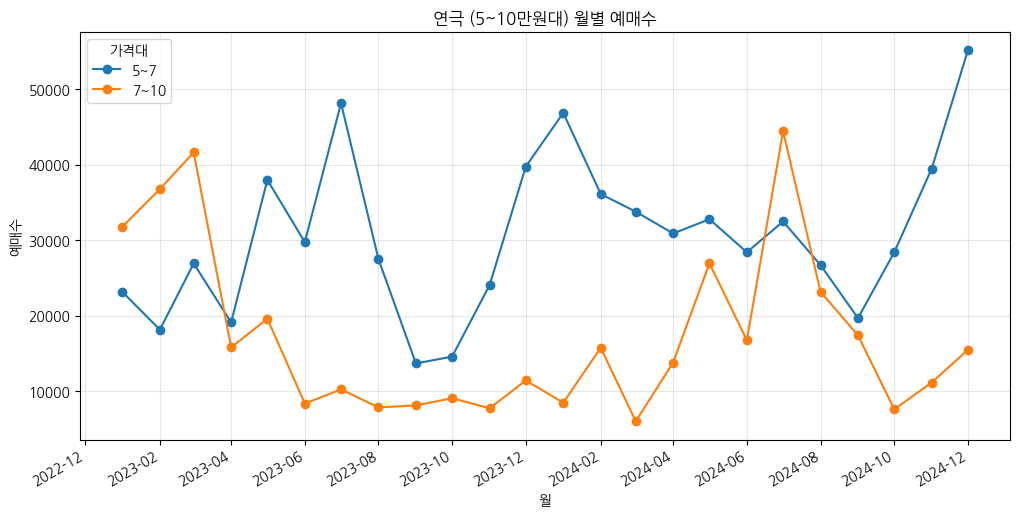

In [118]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 날짜 변환 & 연극만 필터링
price_stats["날짜"] = pd.to_datetime(price_stats["날짜"], format="%Y%m%d", errors="coerce")
price_stats = price_stats.dropna(subset=["날짜"])
play_price_mid = price_stats[
    (price_stats["장르"] == "연극") & 
    (price_stats["가격대"].isin(["5~7", "7~10"]))
].copy()

# 2. 월 단위 집계
play_price_mid["연도"] = play_price_mid["날짜"].dt.year
play_price_mid["월"] = play_price_mid["날짜"].dt.month
play_price_mid["연월"] = pd.to_datetime(play_price_mid["날짜"].dt.to_period("M").astype(str))

monthly = (
    play_price_mid.groupby(["연월","가격대"])["예매수"]
    .sum()
    .reset_index()
)

# 3. 월별 예매수 그래프
fig, ax = plt.subplots(figsize=(12,6))
for price in ["5~7", "7~10"]:
    sub = monthly[monthly["가격대"] == price]
    ax.plot(sub["연월"], sub["예매수"], marker="o", label=price)

# x축 날짜 포맷
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title("연극 (5~10만원대) 월별 예매수")
plt.xlabel("월")
plt.ylabel("예매수")
plt.legend(title="가격대")
plt.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.show()

# 월별 예매수
# 5~7월 : 대극장 중심의 작품 시즌, 방학 휴가 시즌
# 12월 : 연말 특수 + 송년공연 효과

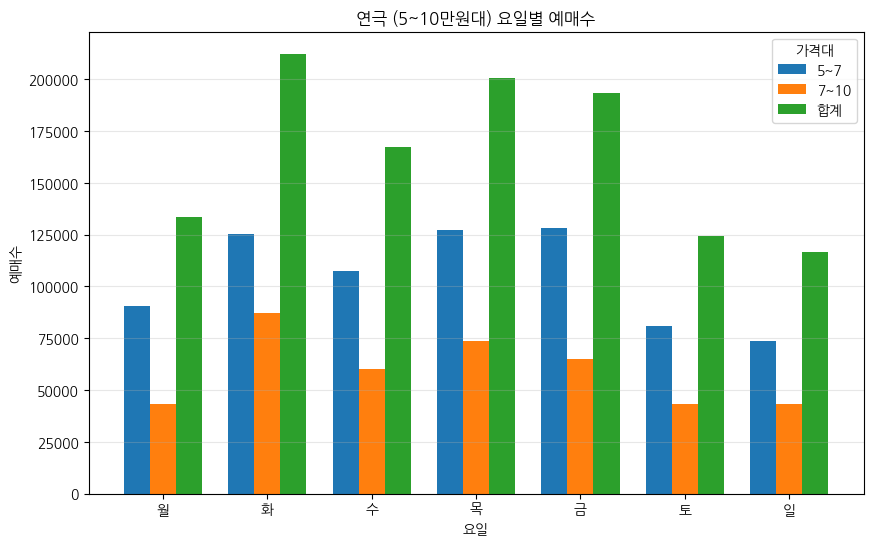

In [ ]:
# ======================
# (B) 요일별 예매수 + 합계
# ======================
play_price_mid["요일"] = play_price_mid["날짜"].dt.dayofweek

weekday = (
    play_price_mid.groupby(["요일","가격대"])["예매수"]
    .sum()
    .reset_index()
)

# 합계 추가
weekday_total = (
    play_price_mid.groupby(["요일"])["예매수"]
    .sum()
    .reset_index()
)
weekday_total["가격대"] = "합계"

weekday_all = pd.concat([weekday, weekday_total], ignore_index=True)

# 막대 그래프
fig, ax = plt.subplots(figsize=(10,6))
labels = ["월","화","수","목","금","토","일"]

width = 0.25
x = weekday_all["요일"].unique()

for i, price in enumerate(["5~7", "7~10", "합계"]):
    sub = weekday_all[weekday_all["가격대"] == price]
    ax.bar(sub["요일"] + (i-1)*width, sub["예매수"], 
           width=width, label=price)

ax.set_xticks(range(7))
ax.set_xticklabels(labels)
plt.title("연극 (5~10만원대) 요일별 예매수")
plt.xlabel("요일")
plt.ylabel("예매수")
plt.legend(title="가격대")
plt.grid(True, alpha=0.3, axis="y")
plt.show()


# 요일
# 화목금에 예매수 최고치 -> 주말보다 평일 공연의 예매수가 더 많음
# -> 평일 저녁 대극장 작품 중심으로 마케팅이 잘 먹힘 ()
# 주말에는 오히려 예매수 줄음 -> 주말에 놀러 나오는 사람들은 고가 연극보단 저가 연극을 택할 것
# 월요일: 최저 예매율 -> 월요일 공연 쉬는 날 많음, 실제 수요도 적음
# -> 월요일에 오는 사람들을 위해 프로모션?


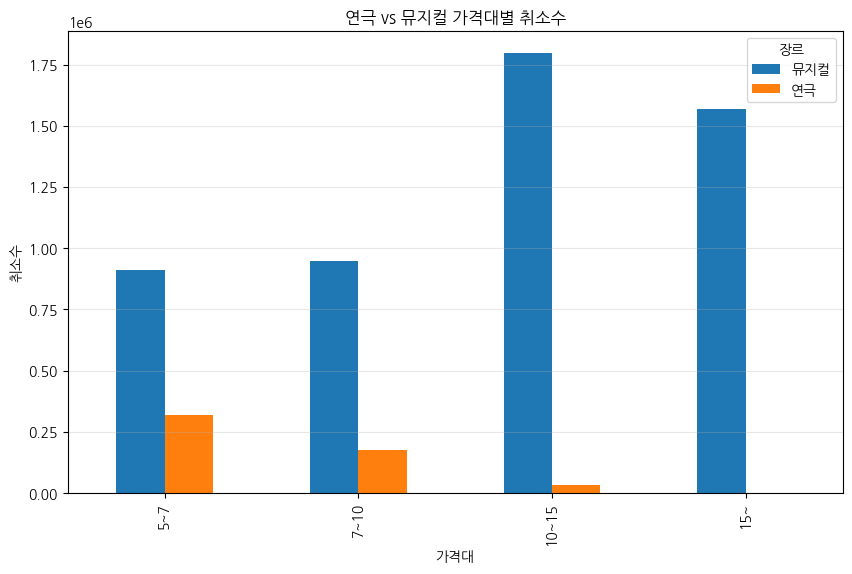

장르         뮤지컬      연극
가격대                   
5~7     909936  319128
7~10    948239  174357
10~15  1796756   32585
15~    1568006     749


In [ ]:
import matplotlib.pyplot as plt

# 1. 분석할 가격대 (순서 지정)
target_prices = ["5~7", "7~10", "10~15", "15~"]

# 2. 연극/뮤지컬만 필터링
df_cancel = price_stats[
    (price_stats["장르"].isin(["연극", "뮤지컬"])) &
    (price_stats["가격대"].isin(target_prices))
].copy()

# 3. 숫자형 변환
df_cancel["취소수"] = pd.to_numeric(df_cancel["취소수"], errors="coerce")

# 4. 그룹화
cancel_stats = (
    df_cancel.groupby(["가격대","장르"])["취소수"]
    .sum()
    .reset_index()
)

# 5. 가격대 순서 정렬
cancel_stats["가격대"] = pd.Categorical(cancel_stats["가격대"], categories=target_prices, ordered=True)
cancel_stats = cancel_stats.sort_values("가격대")

# 6. 피벗 (시각화 편리하게)
pivot_cancel = cancel_stats.pivot(index="가격대", columns="장르", values="취소수").fillna(0)

# 7. 시각화
pivot_cancel.plot(kind="bar", figsize=(10,6))
plt.title("연극 vs 뮤지컬 가격대별 취소수")
plt.xlabel("가격대")
plt.ylabel("취소수")
plt.legend(title="장르")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# 8. 정리된 테이블도 출력
print(pivot_cancel)

# 판매 규모가 적으니 당연히 취소 수 적게 잡힘
# 취소율을 보자


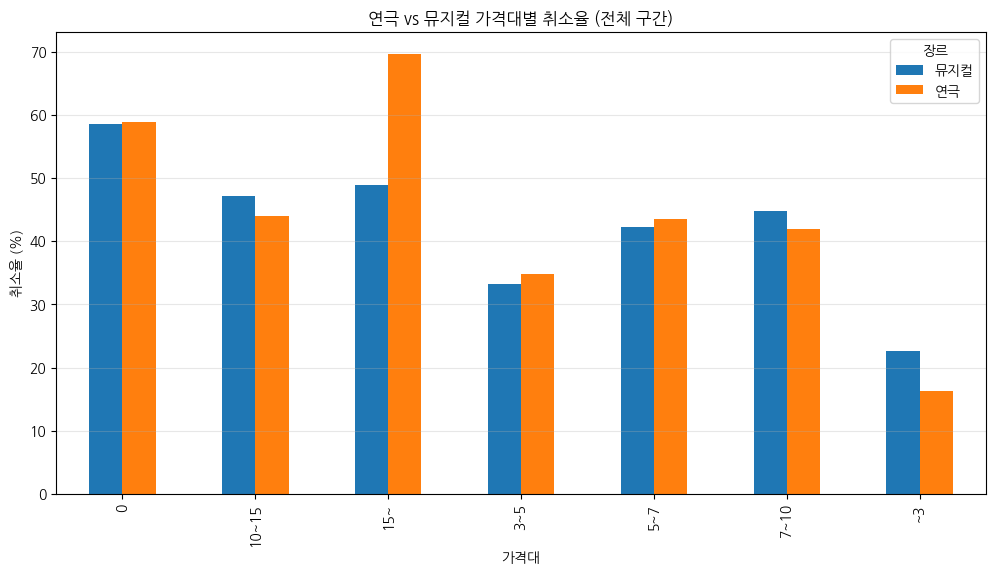

장르       뮤지컬     연극
가격대                
0      58.58  58.82
10~15  47.15  43.96
15~    48.87  69.61
3~5    33.24  34.80
5~7    42.22  43.52
7~10   44.73  41.97
~3     22.64  16.31


In [124]:
import matplotlib.pyplot as plt

# 1. 연극/뮤지컬만 필터링
df_rate_all = price_stats[price_stats["장르"].isin(["연극", "뮤지컬"])].copy()

# 2. 숫자형 변환
df_rate_all["취소수"] = pd.to_numeric(df_rate_all["취소수"], errors="coerce")
df_rate_all["예매수"] = pd.to_numeric(df_rate_all["예매수"], errors="coerce")

# 3. 그룹화 (가격대 × 장르)
cancel_rate_all = (
    df_rate_all.groupby(["가격대","장르"])[["취소수","예매수"]]
    .sum()
    .reset_index()
)

# 4. 취소율 계산
cancel_rate_all["취소율(%)"] = (cancel_rate_all["취소수"] / cancel_rate_all["예매수"]) * 100

# 5. 피벗
pivot_rate_all = cancel_rate_all.pivot(index="가격대", columns="장르", values="취소율(%)").fillna(0)

# 6. 시각화
pivot_rate_all.plot(kind="bar", figsize=(12,6))
plt.title("연극 vs 뮤지컬 가격대별 취소율 (전체 구간)")
plt.xlabel("가격대")
plt.ylabel("취소율 (%)")
plt.legend(title="장르")
plt.grid(True, alpha=0.3, axis="y")
plt.show()

# 7. 표도 확인
print(pivot_rate_all.round(2))


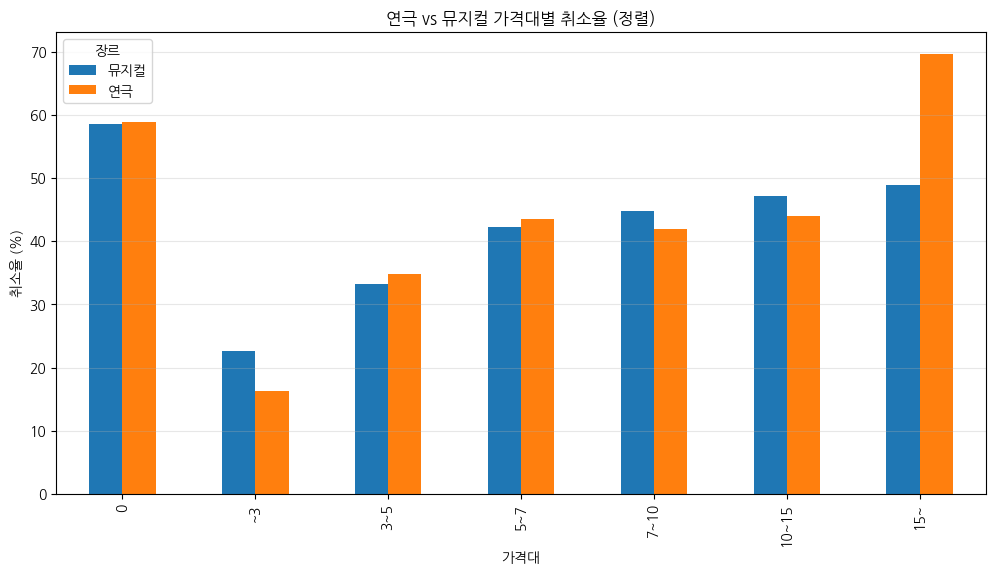

장르       뮤지컬     연극
가격대                
0      58.58  58.82
~3     22.64  16.31
3~5    33.24  34.80
5~7    42.22  43.52
7~10   44.73  41.97
10~15  47.15  43.96
15~    48.87  69.61


In [ ]:
# 1. 원하는 가격대 순서 정의
price_order = ["0", "~3", "3~5", "5~7", "7~10", "10~15", "15~"]

# 2. 연극/뮤지컬만 필터링
df_rate_all = price_stats[price_stats["장르"].isin(["연극", "뮤지컬"])].copy()

# 3. 숫자형 변환
df_rate_all["취소수"] = pd.to_numeric(df_rate_all["취소수"], errors="coerce")
df_rate_all["예매수"] = pd.to_numeric(df_rate_all["예매수"], errors="coerce")

# 4. 그룹화
cancel_rate_all = (
    df_rate_all.groupby(["가격대","장르"])[["취소수","예매수"]]
    .sum()
    .reset_index()
)

# 5. 취소율 계산
cancel_rate_all["취소율(%)"] = (cancel_rate_all["취소수"] / cancel_rate_all["예매수"]) * 100

# 6. 가격대 순서 지정
cancel_rate_all["가격대"] = pd.Categorical(cancel_rate_all["가격대"], 
                                        categories=price_order, 
                                        ordered=True)
cancel_rate_all = cancel_rate_all.sort_values("가격대")

# 7. 피벗
pivot_rate_all = cancel_rate_all.pivot(index="가격대", columns="장르", values="취소율(%)").fillna(0)

# 8. 시각화
pivot_rate_all.plot(kind="bar", figsize=(12,6))
plt.title("연극 vs 뮤지컬 가격대별 취소율 (정렬)")
plt.xlabel("가격대")
plt.ylabel("취소율 (%)")
plt.legend(title="장르")
plt.grid(True, alpha=0.3, axis="y")
plt.show()

# 9. 확인용 테이블
print(pivot_rate_all.round(2))

# 저가(3만원 미만): 취소율이 상대적으로 낮음 → 가볍게 예매하고 그대로 관람까지 이어지는 경향.
# 중가(5~10만원): 뮤지컬과 큰 차이가 없어짐 → 이 구간부터는 연극도 “뮤지컬 수준”의 고민을 하게 되는 듯.
# 고가(15만원 이상): 취소율이 뮤지컬보다 훨씬 높음 → *“연극에 고가를 지불하는 건 부담스럽다”*라는 소비자 심리가 반영된 것으로 보임.


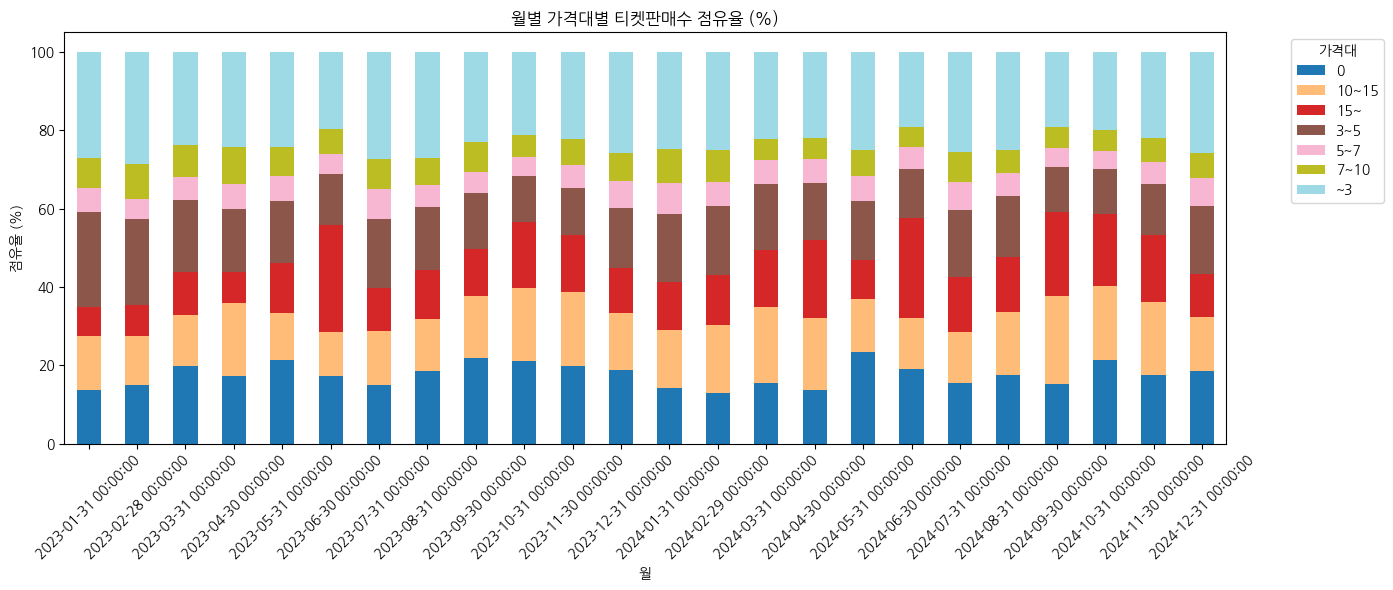

In [130]:
import matplotlib.pyplot as plt

# 1. 월 단위 집계 (총 티켓판매수 합계)
monthly_sales = (
    price_stats.groupby([pd.Grouper(key="날짜", freq="M"), "가격대"])["총 티켓판매수"]
    .sum()
    .reset_index()
)

# 2. 피벗 (행=월, 열=가격대, 값=총 티켓판매수)
pivot_sales = monthly_sales.pivot(index="날짜", columns="가격대", values="총 티켓판매수").fillna(0)

# 3. 점유율 계산
pivot_share = pivot_sales.div(pivot_sales.sum(axis=1), axis=0) * 100

# 4. Stacked Bar Chart
fig, ax = plt.subplots(figsize=(14,6))
pivot_share.plot(kind="bar", stacked=True, ax=ax, cmap="tab20")

plt.title("월별 가격대별 티켓판매수 점유율 (%)")
plt.xlabel("월")
plt.ylabel("점유율 (%)")
plt.xticks(rotation=45)
plt.legend(title="가격대", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

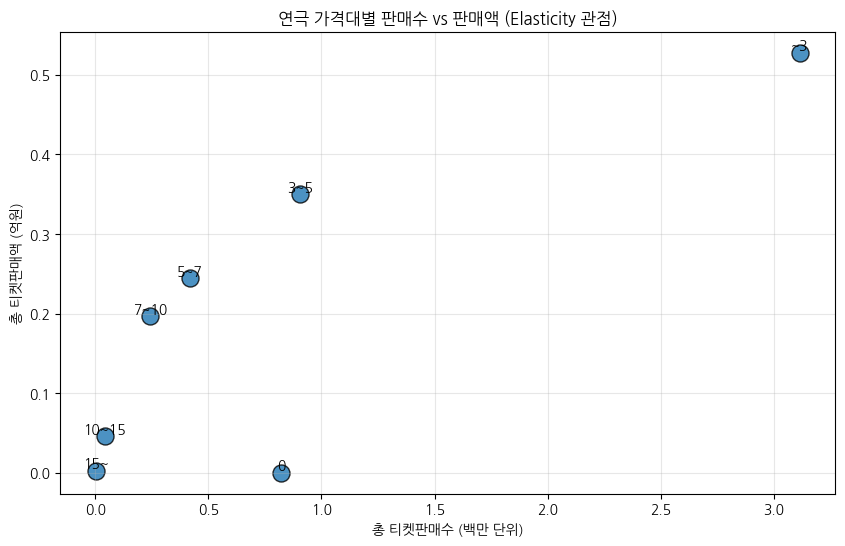

In [137]:
import matplotlib.pyplot as plt

# 🎭 연극만 필터링
play_stats = price_stats[price_stats["장르"] == "연극"].copy()

# 1. 가격대별 집계
scatter_data = (
    play_stats.groupby("가격대")[["총 티켓판매수", "총 티켓판매액"]]
    .sum()
    .reset_index()
)

# 2. 단위 변환
scatter_data["총 티켓판매수_백만"] = scatter_data["총 티켓판매수"] / 1e6
scatter_data["총 티켓판매액_억"] = scatter_data["총 티켓판매액"] / 1e8

# 3. 스캐터 플롯
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(
    scatter_data["총 티켓판매수_백만"], 
    scatter_data["총 티켓판매액_억"],  
    s=150, alpha=0.8, cmap="tab10", edgecolor="black"
)

# 라벨 추가
for i, row in scatter_data.iterrows():
    ax.text(row["총 티켓판매수_백만"], row["총 티켓판매액_억"], row["가격대"], 
            fontsize=10, ha="center", va="bottom")

plt.title("연극 가격대별 판매수 vs 판매액 (Elasticity 관점)")
plt.xlabel("총 티켓판매수 (백만 단위)")
plt.ylabel("총 티켓판매액 (억원)")
plt.grid(True, alpha=0.3)
plt.show()

총 판매수: 906,905
손익분기 판매수: 544,143
손익분기 감소율: 40.0%


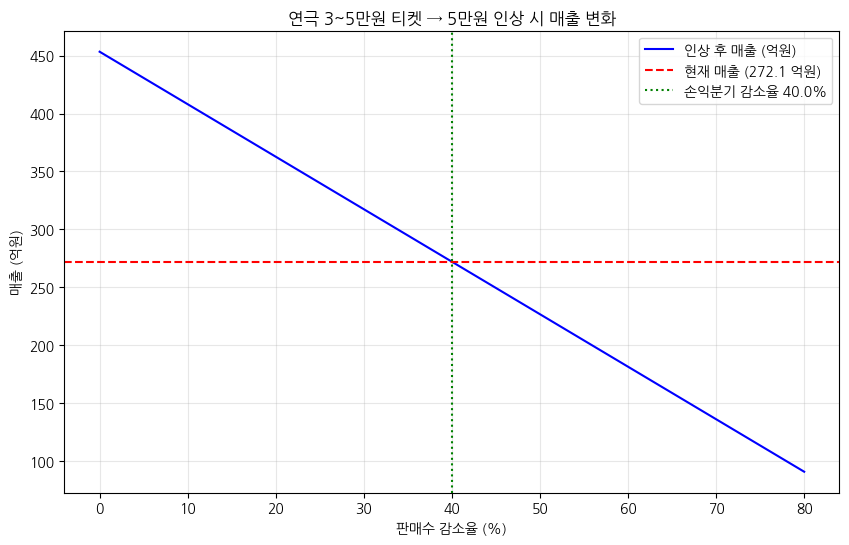

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 🎭 연극만 필터링
play_price_stats = price_stats[price_stats["장르"] == "연극"].copy()

# 3~5만원대 집계
target_data = play_price_stats[play_price_stats["가격대"] == "3~5"]
total_sales = target_data["총 티켓판매수"].sum()
total_revenue = target_data["총 티켓판매액"].sum()

# 현재 가격과 인상 가격
P_now = 30000
P_new = 50000
Q_now = total_sales
R_now = P_now * Q_now

# 손익분기점 판매수
Q_break = R_now / P_new
decrease_rate_break = 1 - (Q_break / Q_now)

print(f"총 판매수: {Q_now:,}")
print(f"손익분기 판매수: {Q_break:,.0f}")
print(f"손익분기 감소율: {decrease_rate_break:.1%}")

# 📊 매출 변화 시뮬레이션
decrease_rates = np.linspace(0, 0.8, 50)  # 판매수 감소율 0%~80%
Q_new = Q_now * (1 - decrease_rates)
R_new = P_new * Q_new

plt.figure(figsize=(10,6))
plt.plot(decrease_rates*100, R_new/1e8, label="인상 후 매출 (억원)", color="blue")
plt.axhline(R_now/1e8, color="red", linestyle="--", label=f"현재 매출 ({R_now/1e8:.1f} 억원)")
plt.axvline(decrease_rate_break*100, color="green", linestyle=":", 
            label=f"손익분기 감소율 {decrease_rate_break*100:.1f}%")

plt.title("연극 3~5만원 티켓 → 5만원 인상 시 매출 변화")
plt.xlabel("판매수 감소율 (%)")
plt.ylabel("매출 (억원)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


3만원대 티켓 → 5만원으로 인상

화·목·금은 어차피 사람들이 집중적으로 예매하는 날이라, 가격 인상 후에도 이탈률이 낮을 가능성이 높음.

아까 계산한 것처럼 이탈률이 40% 이하라면 무조건 이득이므로, 화·목·금 요일에 한해 가격 인상 전략을 쓰면 리스크 최소화 + 매출 상승 효과를 동시에 얻을 수 있음.|

화·목·금에만 5만원 이상 구간의 좌석을 한정 제공

“프라임 요일 특별가”처럼 브랜딩하면 소비자 반발도 줄일 수 있음.

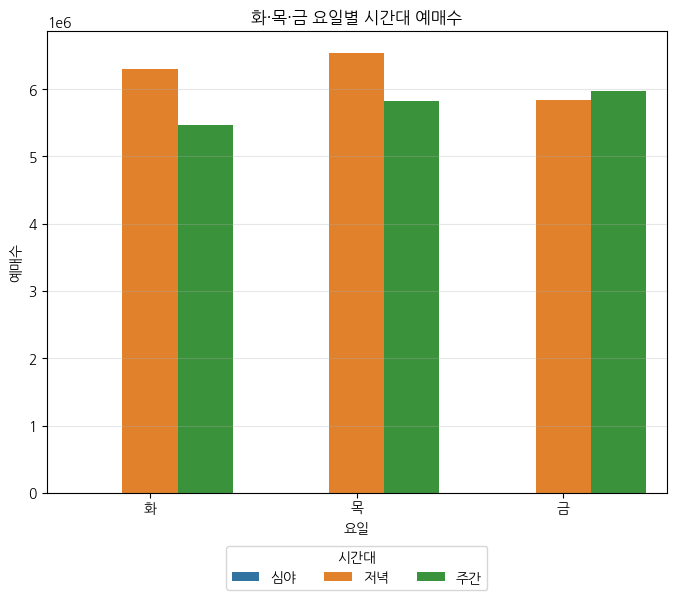

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 변환 & 요일 추가
time_stats["날짜"] = pd.to_datetime(time_stats["날짜"], format="%Y%m%d", errors="coerce")

# 요일 번호 반환 (0=월요일, ..., 6=일요일)
time_stats["요일번호"] = time_stats["날짜"].dt.dayofweek

# 국문 매핑 딕셔너리
weekday_map = {
    0: "월",
    1: "화",
    2: "수",
    3: "목",
    4: "금",
    5: "토",
    6: "일"
}

# 국문 요일 컬럼 추가
time_stats["요일"] = time_stats["요일번호"].map(weekday_map)

# 화·목·금만 필터링
filtered = time_stats[time_stats["요일"].isin(["화", "목", "금"])]

# 요일 × 시간대 집계
grouped = (
    filtered.groupby(["요일", "시간대_대분류"])
    .agg({"예매수": "sum"})
    .reset_index()
)

# 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=grouped, x="요일", y="예매수", hue="시간대_대분류", order=["화", "목", "금"])

plt.title("화·목·금 요일별 시간대 예매수")
plt.ylabel("예매수")
plt.xlabel("요일")
plt.legend(
    title="시간대",
    loc="upper center",        # 위쪽 중앙
    bbox_to_anchor=(0.5, -0.1),  # (x, y) 좌표 → y=-0.1로 그래프 아래쪽
    ncol=3                     # 가로로 3열 정렬
)
plt.grid(axis="y", alpha=0.3)
plt.show()


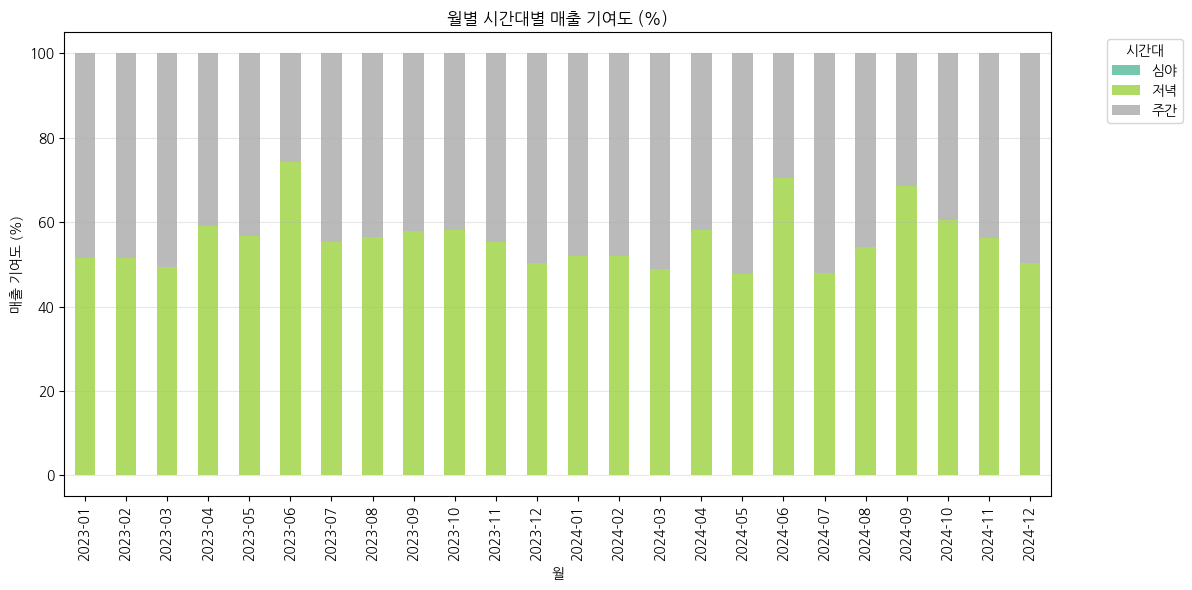

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 날짜 변환
time_stats["날짜"] = pd.to_datetime(time_stats["날짜"], format="%Y%m%d", errors="coerce")

# 월 단위 집계
monthly_sales = (
    time_stats.groupby([pd.Grouper(key="날짜", freq="MS"), "시간대_대분류"])
    .agg({"총티켓판매액": "sum"})
    .reset_index()
)

# 전체 매출 대비 비중 계산
monthly_sales["총매출"] = monthly_sales.groupby("날짜")["총티켓판매액"].transform("sum")
monthly_sales["매출비중"] = monthly_sales["총티켓판매액"] / monthly_sales["총매출"] * 100

# 월 단위 라벨 변환 (2023-01 형태)
monthly_sales["월"] = monthly_sales["날짜"].dt.to_period("M").astype(str)

# 피벗 (월 × 시간대)
pivot_sales = monthly_sales.pivot(index="월", columns="시간대_대분류", values="매출비중")

# stacked bar chart
pivot_sales.plot(
    kind="bar", stacked=True, figsize=(12,6),
    colormap="Set2", alpha=0.9
)

plt.title("월별 시간대별 매출 기여도 (%)")
plt.ylabel("매출 기여도 (%)")
plt.xlabel("월")
plt.legend(title="시간대", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 겨울에는 또이또이
# 여름에는 해가 길어서 그런지 저녁 시간대가 매우 잘팔림

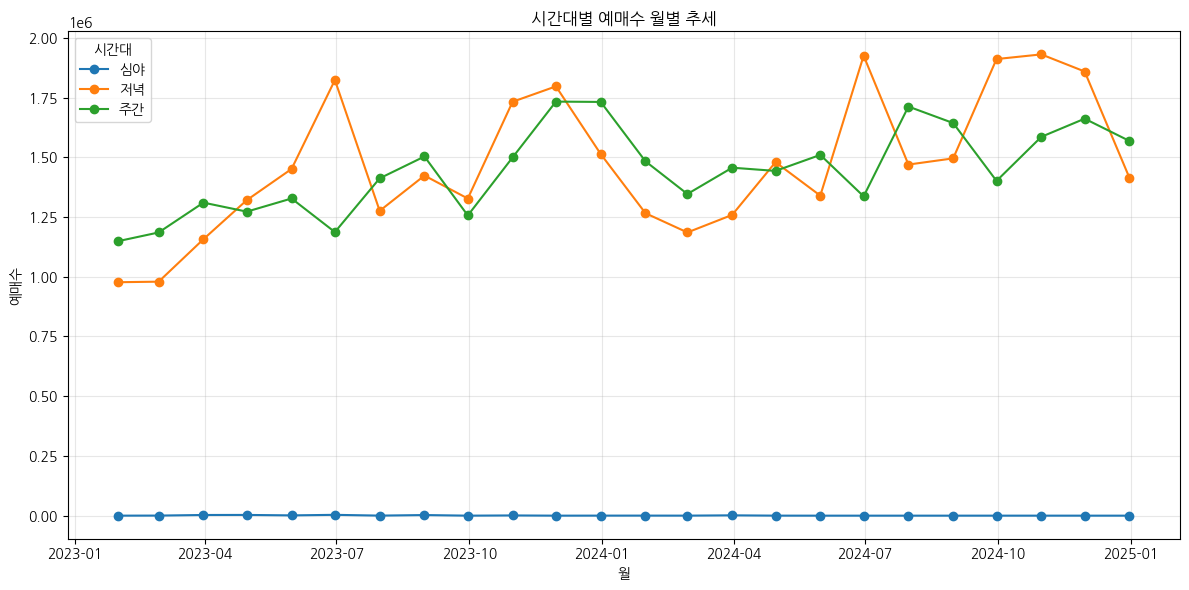

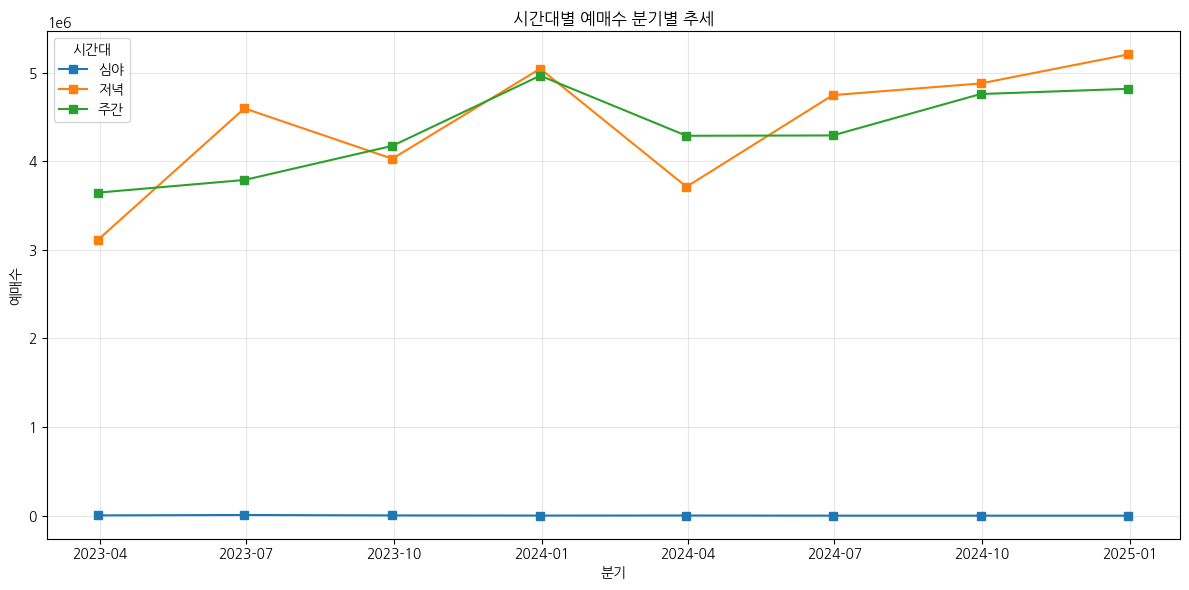

In [149]:
import matplotlib.pyplot as plt
import pandas as pd

# 날짜 변환
time_stats["날짜"] = pd.to_datetime(time_stats["날짜"], format="%Y%m%d", errors="coerce")

# ========================
# 1) 월 단위 트렌드
# ========================
monthly_trend = (
    time_stats.groupby([pd.Grouper(key="날짜", freq="M"), "시간대_대분류"])
    .agg({"예매수": "sum"})
    .reset_index()
)

plt.figure(figsize=(12,6))
for t in monthly_trend["시간대_대분류"].unique():
    subset = monthly_trend[monthly_trend["시간대_대분류"] == t]
    plt.plot(subset["날짜"], subset["예매수"], marker="o", label=t)

plt.title("시간대별 예매수 월별 추세")
plt.ylabel("예매수")
plt.xlabel("월")
plt.legend(title="시간대")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ========================
# 2) 분기 단위 트렌드
# ========================
quarterly_trend = (
    time_stats.groupby([pd.Grouper(key="날짜", freq="Q"), "시간대_대분류"])
    .agg({"예매수": "sum"})
    .reset_index()
)

plt.figure(figsize=(12,6))
for t in quarterly_trend["시간대_대분류"].unique():
    subset = quarterly_trend[quarterly_trend["시간대_대분류"] == t]
    plt.plot(subset["날짜"], subset["예매수"], marker="s", label=t)

plt.title("시간대별 예매수 분기별 추세")
plt.ylabel("예매수")
plt.xlabel("분기")
plt.legend(title="시간대")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


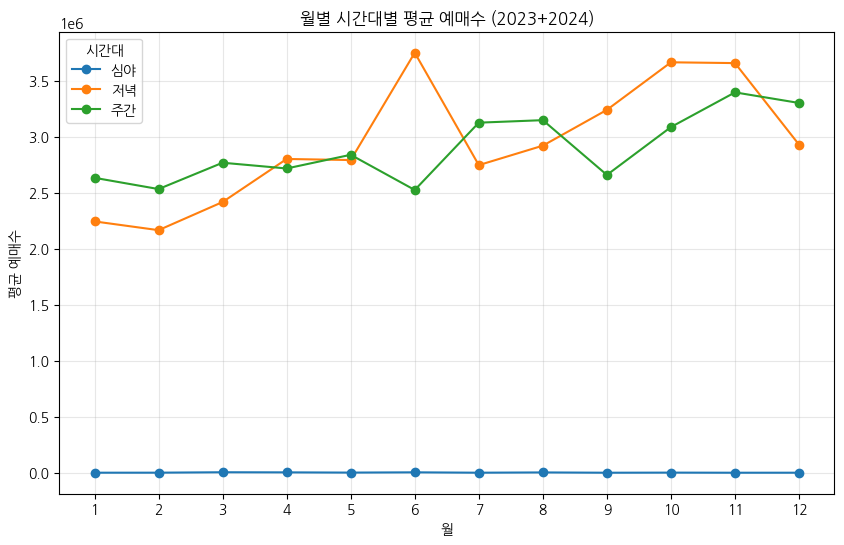

In [150]:
import matplotlib.pyplot as plt
import pandas as pd

# 날짜 변환
time_stats["날짜"] = pd.to_datetime(time_stats["날짜"], format="%Y%m%d", errors="coerce")

# 월/시간대별 집계
monthly_trend = (
    time_stats.groupby([time_stats["날짜"].dt.month, "시간대_대분류"])
    .agg({"예매수": "sum"})
    .reset_index()
    .rename(columns={"날짜": "월"})
)

# 두 개년(2023+2024) 평균 계산
monthly_avg = (
    monthly_trend.groupby(["월", "시간대_대분류"])["예매수"]
    .mean()
    .reset_index()
)

# 피벗 (월 × 시간대)
pivot_avg = monthly_avg.pivot(index="월", columns="시간대_대분류", values="예매수")

# 시각화
plt.figure(figsize=(10,6))
for col in pivot_avg.columns:
    plt.plot(pivot_avg.index, pivot_avg[col], marker="o", label=col)

plt.title("월별 시간대별 평균 예매수 (2023+2024)")
plt.xlabel("월")
plt.ylabel("평균 예매수")
plt.xticks(range(1,13))
plt.legend(title="시간대")
plt.grid(True, alpha=0.3)
plt.show()


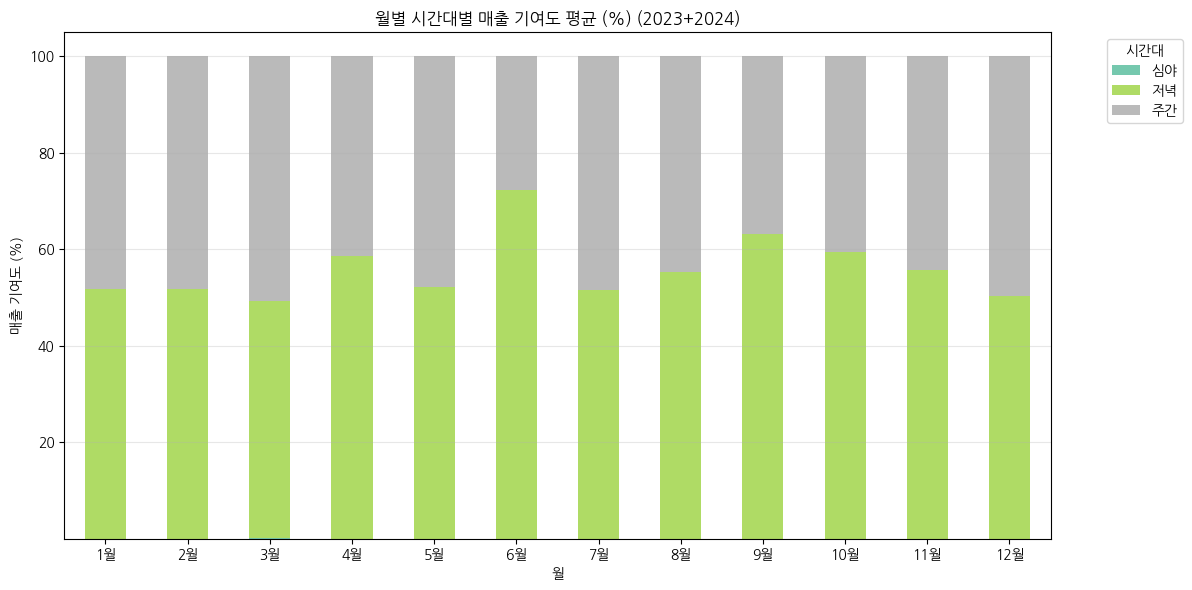

In [151]:
import matplotlib.pyplot as plt
import pandas as pd

# 날짜 변환
time_stats["날짜"] = pd.to_datetime(time_stats["날짜"], format="%Y%m%d", errors="coerce")

# 월 단위 집계
monthly_sales = (
    time_stats.groupby([pd.Grouper(key="날짜", freq="MS"), "시간대_대분류"])
    .agg({"총티켓판매액": "sum"})
    .reset_index()
)

# 전체 매출 대비 비중 계산
monthly_sales["총매출"] = monthly_sales.groupby("날짜")["총티켓판매액"].transform("sum")
monthly_sales["매출비중"] = monthly_sales["총티켓판매액"] / monthly_sales["총매출"] * 100

# 👉 월(숫자) 추출
monthly_sales["월"] = monthly_sales["날짜"].dt.month

# 두 개년(2023+2024) 평균
monthly_avg = (
    monthly_sales.groupby(["월", "시간대_대분류"])["매출비중"]
    .mean()
    .reset_index()
)

# 피벗 (월 × 시간대)
pivot_avg = monthly_avg.pivot(index="월", columns="시간대_대분류", values="매출비중")

# stacked bar chart
pivot_avg.plot(
    kind="bar", stacked=True, figsize=(12,6),
    colormap="Set2", alpha=0.9
)

plt.title("월별 시간대별 매출 기여도 평균 (%) (2023+2024)")
plt.ylabel("매출 기여도 (%)")
plt.xlabel("월")
plt.xticks(range(0,12), [f"{m}월" for m in range(1,13)], rotation=0)
plt.legend(title="시간대", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
merged_price_genre = price_stats.merge(
    genre_service[['날짜', '장르', '관객수', '매출액']],
    on=['날짜', '장르'],
    how='left'
)

In [21]:
merged_price_genre["총 티켓판매수_장르비중(%)"] = (
    merged_price_genre["총 티켓판매수_장르비중(%)"]
    .replace("###.#", "0")
)

In [22]:
merged_price_genre['예상관객수'] = merged_price_genre['관객수'] * (merged_price_genre['총 티켓판매수_장르비중(%)'].astype(float) / 100)

In [34]:
merged_price_genre['예상매출액'] = (
    merged_price_genre['매출액'] *
    (merged_price_genre['총 티켓판매수_장르비중(%)'].astype(float) / 100)
)

In [34]:
import re

# 요일 리스트 (한국어 → 번호 매핑)
weekdays = ["월", "화", "수", "목", "금", "토", "일"]
weekday_map = {day: i for i, day in enumerate(weekdays)}

def expand_schedule(schedule):
    results = []
    # 괄호 안 시간 추출
    parts = re.findall(r"([월화수목금토일](?:요일)?(?:\s*~\s*[월화수목금토일](?:요일)?)?)\((.*?)\)", schedule)
    
    for day_expr, times in parts:
        # 요일 범위 처리
        if "~" in day_expr:
            start, end = [d.replace("요일","").strip() for d in day_expr.split("~")]
            start_idx, end_idx = weekday_map[start], weekday_map[end]
            days = weekdays[start_idx:end_idx+1]
        else:
            days = [day_expr.replace("요일","").strip()]
        
        # 시간 여러 개면 split
        time_list = [t.strip() for t in times.split(",")]
        
        # 요일-시간 조합
        for d in days:
            for t in time_list:
                results.append((d, t))
    return results

In [35]:
performance_play_test = performance_play.copy()

In [36]:
performance_play_test["요일시간"] = performance_play_test["공연시간"].apply(
    lambda x: expand_schedule(x) if isinstance(x, str) else []
)

In [37]:
def runtime_to_minutes(x):
    if not isinstance(x, str):
        return None
    hours = 0
    minutes = 0
    
    # "숫자시간" 패턴 찾기
    h_match = re.search(r"(\d+)시간", x)
    if h_match:
        hours = int(h_match.group(1))
    
    # "숫자분" 패턴 찾기
    m_match = re.search(r"(\d+)분", x)
    if m_match:
        minutes = int(m_match.group(1))
    
    return hours * 60 + minutes

In [38]:
performance_play_test["런타임_분"] = performance_play_test["런타임"].apply(runtime_to_minutes)

In [39]:
performance_play_test = performance_play_test.explode("요일시간").reset_index(drop=True)
performance_play_test[["요일","공연시각"]] = pd.DataFrame(performance_play_test["요일시간"].tolist(), index=performance_play_test.index)

In [40]:
bins = list(range(0, 25, 3))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

def get_time_slots(start_time, runtime):
    if pd.isna(start_time) or pd.isna(runtime):
        return []
    
    # 시작/끝 시간 계산
    start_h = int(start_time.split(":")[0])
    end_h = start_h + (runtime // 60) + (1 if runtime % 60 > 0 else 0)  # 올림
    if end_h > 24: 
        end_h = 24  # 자정 넘으면 잘라줌
    
    slots = []
    for i in range(len(bins)-1):
        s, e = bins[i], bins[i+1]
        # 공연 구간 [start_h, end_h)와 시간대 [s, e) 겹치면 포함
        if not (end_h <= s or start_h >= e):
            slots.append(f"{s}-{e}")
    return slots

In [41]:
performance_play_test['시간대_그룹'] = performance_play_test.apply(lambda row: get_time_slots(row['공연시각'], row['런타임_분']), axis=1)

In [42]:
performance_play_test = performance_play_test.explode('시간대_그룹').reset_index(drop=True)

In [55]:
# 매핑 딕셔너리
price_bins = [
    (0, 1, "0"),
    (1, 30000, "~3"),
    (30000, 50000, "3~5"),
    (50000, 70000, "5~7"),
    (70000, 100000, "7~10"),
    (100000, 150000, "10~15"),
    (150000, float("inf"), "15~")
]

def map_price_to_range(price):
    for low, high, label in price_bins:
        if low <= price < high:
            return label
    return None

In [57]:
performance_play_test.티켓가격_list.value_counts()

티켓가격_list
[30000]                         6866
[40000]                         3292
[50000]                         3181
[35000]                         2931
[20000]                         2493
                                ... 
[20000, 50000]                     1
[40000, 22000, 28000, 18000]       1
[80000, 50000, 30000]              1
[48000]                            1
[49000]                            1
Name: count, Length: 153, dtype: int64

In [65]:
import ast

performance_play_test["티켓가격_list"] = performance_play_test["티켓가격_list"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

performance_play_test["가격대"] = performance_play_test["티켓가격_list"].apply(
    lambda prices: [map_price_to_range(int(str(p).replace(",", "").strip())) for p in prices]
    if isinstance(prices, list) else []
)

In [74]:
performance_play_test = performance_play_test.explode("가격대").reset_index(drop=True)

In [75]:
performance_play_test = performance_play_test.to_csv("../datasets/KOPIS/statics/공연상세정보(시간대+가격대).csv", index=False, encoding="utf-8-sig")

In [28]:
from datetime import timedelta

def expand_dates(row):
    START = pd.Timestamp("2023-01-01")
    END = pd.Timestamp("2024-12-31")
    
    start = max(row['공연시작일'], START)
    end = min(row['공연종료일'], END)
    
    if start > end:
        return []
    
    dates = pd.date_range(start, end, freq="D").strftime("%Y%m%d").tolist()
    return list(dates)

In [29]:
performance_play_test["상연일"] = performance_play_test.apply(expand_dates, axis=1)

In [30]:
play_date_map = performance_play_test[["공연ID", "상연일"]].copy()

In [31]:
play_date_map = play_date_map.explode("상연일").reset_index(drop=True)

In [33]:
play_date_map.to_csv("../datasets/KOPIS/statics/상연일자별공연ID목록.csv", index=False, encoding="utf-8-sig")

In [81]:
performance_play = pd.read_csv("../datasets/KOPIS/statics/공연상세정보(시간대+가격대).csv")

In [82]:
performance_play.columns

Index(['공연ID', '공연명', '공연시작일', '공연종료일', '공연시설명', '출연진', '제작진', '런타임', '관람연령',
       '제작사', '기획사', '주최', '주관', '티켓가격', '포스터URL', '줄거리', '공연지역', '공연장르명',
       '오픈런', '내한여부', '아동공연여부', '대학로공연여부', '축제여부', '뮤지컬라이센스', '뮤지컬창작', '최종수정일',
       '공연상태', '공연시설ID', '공연시간', '장르(통계)', '상연횟수', '공연명(통계)', '공연시설명(통계)',
       '공연시작일(통계)', '공연종료일(통계)', '연도(통계)', '월(통계)', '장르코드(통계)', '티켓가격_list',
       '최소가격', '최대가격', '요일시간', '런타임_분', '요일', '공연시각', '시간대_그룹', '가격대'],
      dtype='object')

In [83]:
performance_play.drop(columns=['뮤지컬라이센스', '뮤지컬창작', '최종수정일', '장르(통계)', '공연명(통계)', '공연시설명(통계)',
                               '공연시작일(통계)', '공연종료일(통계)', '연도(통계)', '월(통계)', '장르코드(통계)'], axis=1, inplace=True)

In [85]:
performance_play.to_csv("../datasets/KOPIS/statics/연극상세정보(시간대+가격대).csv", index=False, encoding="utf-8-sig")

In [86]:
# performance_play에 등장한 공연시설ID만 추출
facility_ids = performance_play["공연시설ID"].unique()

# facility_df에서 해당 ID만 필터링
facility_df_filtered = facility_df[facility_df["공연시설ID"].isin(facility_ids)].copy()

print(f"원본 시설 수: {len(facility_df)} → 필터링 후: {len(facility_df_filtered)}")

원본 시설 수: 1376 → 필터링 후: 437


In [87]:
facility_2023_2024_play = facility_df_filtered.copy()

In [105]:
facility_2023_2024_play.to_csv("../streamlit_play/datasets/공연시설상세정보(2324연극).csv", index=False, encoding="utf-8-sig")

In [104]:
facility_2023_2024_play.to_csv("../datasets/KOPIS/statics/공연시설상세정보(2324연극).csv", index=False, encoding="utf-8-sig")

In [103]:
1 % 12 // 3 + 1

1